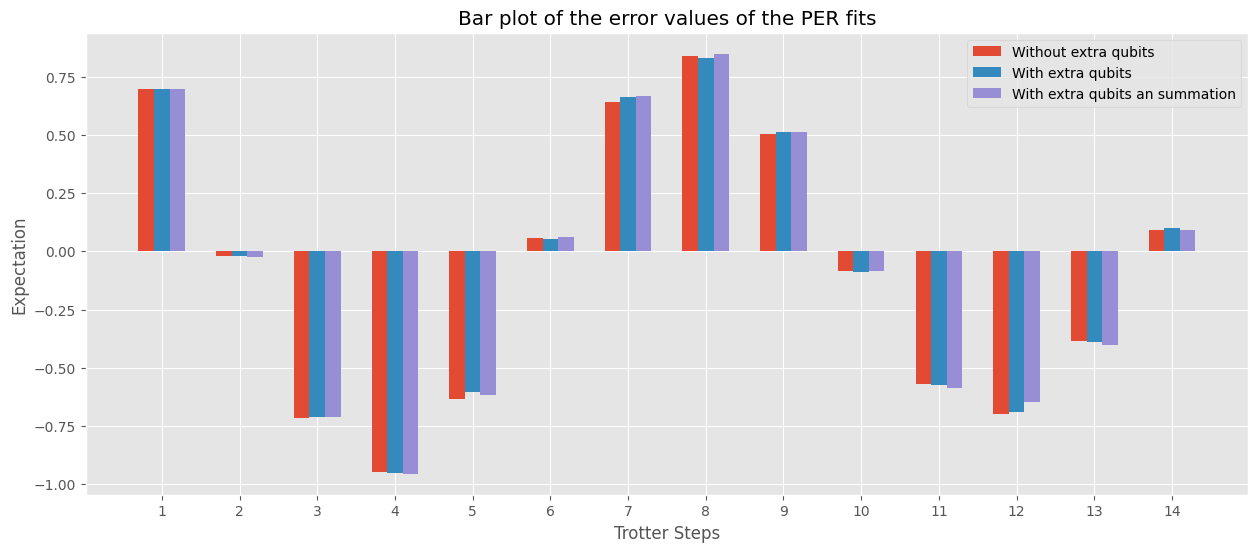

In [15]:
# %%
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.providers.fake_provider import FakeMelbourneV2
from matplotlib import pyplot as plt
import os
import sys
import numpy as np
import argparse
import json

backend = FakeMelbourneV2()

folder = os.getcwd()
while not folder.endswith("AutomatedPERTools"):
    folder = os.path.dirname(folder)
sys.path.append(os.path.join(folder, "pauli_lindblad_per"))

from tomography.experiment import SparsePauliTomographyExperiment as tomography
from primitives.pauli import QiskitPauli

plt.style.use("ggplot")

# %% Make Circuits
qubits = [9,10,11,12]
def trotterLayer(h,J,dt,n):
    n=2
    trotterLayer = QuantumCircuit(14)
    trotterLayer.rx(dt*4*h, qubits)
    trotterLayer.cx(*zip(*[(qubits[2*i], qubits[2*i+1]) for i in range(n)]))
    trotterLayer.rz(-4*J*dt, [qubits[2*i+1] for i in range(n)])
    trotterLayer.cx(*zip(*[(qubits[2*i], qubits[2*i+1]) for i in range(n)]))
    trotterLayer.cx(*zip(*[(qubits[2*i+1], qubits[2*i+2]) for i in range(n-1)]))
    trotterLayer.rz(-4*J*dt, [qubits[2*i+2] for i in range(n-1)])
    trotterLayer.cx(*zip(*[(qubits[2*i+1], qubits[2*i+2]) for i in range(n-1)]))
    return trotterLayer

h = 1
J = -.15
dt = .2
n = 2

def maketrotterCircuit(s):
    tL = trotterLayer(h, J, dt, n)
    trotterCircuit = QuantumCircuit(14)
    for i in range(s):
        trotterCircuit = trotterCircuit.compose(tL)
        trotterCircuit.barrier()

    transpiled = transpile(trotterCircuit, backend)
    return transpiled

circuits = [maketrotterCircuit(i) for i in range(1,15)]

noise_strengths = [0,0.5,1,2]
expectations = []
for q in qubits:
    expect = "I"*14 #15-1
    expect = expect[:q] + 'Z' + expect[q+1:]
    expectations.append(expect)
# %%

jsonfiles = ["/home/fabrice/Dokumente/Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun-results-fakevigoV2/FalseFalse_arrays.json",
"/home/fabrice/Dokumente/Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun-results-fakevigoV2/TrueFalse_arrays.json",
"/home/fabrice/Dokumente/Masterarbeit/AutomatedPERTools/tutorial_notebooks/testrun/testrun-results-fakevigoV2/TrueTrue_arrays.json"]
namebases = []
data = {}
for jfilename in jsonfiles:
    namebase = os.path.basename(jfilename)
    namebase = namebase[:len(namebase)-12]
    namebases.append(namebase)
    with open(jfilename, 'r') as file:
        data[namebase] = json.load(file) # names are: results, results_errors, results_at_noise, results_at_noise_errors, noisyresult, res
    data[namebase]["results_total_errors"] = [abs(a[0]) + abs(a[1]) for a in data[namebase]["results_errors"]]
    #data[namebase]["results_total_errors"] = data[namebase]["results"]

import matplotlib.pyplot as plt
import numpy as np

# Sample data
a = data[namebases[0]]["results_total_errors"]
b = data[namebases[1]]["results_total_errors"]
c = data[namebases[2]]["results_total_errors"]

# Number of bars
n = len(a)

# Positions of groups on the x-axis
ind = np.arange(n)

# Width of bars
width = 0.2

# Create a bar plot
fig, ax = plt.subplots(figsize=(15,6))
# Plotting the bars
bar1 = ax.bar(ind - width, a, width, label="Without extra qubits")#namebases[0])
bar2 = ax.bar(ind, b, width, label="With extra qubits")
bar3 = ax.bar(ind + width, c, width, label="With extra qubits an summation")

# Adding labels
ax.set_xlabel('Trotter Steps')
ax.set_ylabel('Expectation')
ax.set_title('Bar plot of the error values of the PER fits')
ax.set_xticks(ind)
ax.set_xticklabels([f'{i+1}' for i in range(n)])

# Add a legend
ax.legend()

# Show the plot
plt.show()